In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import sys
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
sys.path.append('/kaggle/input/enron-project/')
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/enron-email-dataset/emails.csv
/kaggle/input/gaurav123/tester.py
/kaggle/input/gaurav123/feature_format.py
/kaggle/input/gaurav123/final_project_dataset.pkl


In [2]:
import pickle
original = "/kaggle/input/gaurav123/final_project_dataset.pkl"
destination = "modified_final_project_dataset.pkl"

content = ''
outsize = 0
with open(original, 'rb') as infile:
    content = infile.read()
with open(destination, 'wb') as output:
    for line in content.splitlines():
        outsize += len(line) + 1
        output.write(line + str.encode('\n'))

In [3]:
def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    return_list = []
    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print ("error: key ", feature, " not present")
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)

def targetFeatureSplit( data ):
    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )

    return target, features

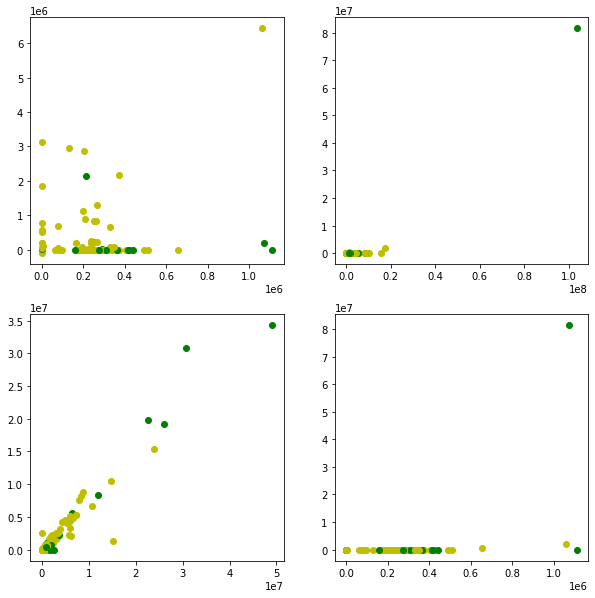

In [4]:
#plotting graphs for various features
enron_data = pickle.load(open("modified_final_project_dataset.pkl", 'rb') )
enron_data.pop('TOTAL')
import matplotlib.pyplot as plt
from sklearn import preprocessing
fig,a=plt.subplots(2,2,squeeze=False,figsize=(10,10))
#graphs for various features to decide which features to include
x1=featureFormat(enron_data,["poi","salary","deferral_payments"])
for y in range(len(x1)):
    if x1[y][0]==True:
        a[0][0].scatter(x1[y][1],x1[y][2],color='g')
    else:
        a[0][0].scatter(x1[y][1],x1[y][2],color='y')
x2=featureFormat(enron_data,["poi","total_payments","loan_advances"])
for z in range(len(x2)):
    if x2[z][0]==True:
        a[0][1].scatter(x2[z][1],x2[z][2],color='g')
    else:
        a[0][1].scatter(x2[z][1],x2[z][2],color='y')
x3=featureFormat(enron_data,["poi","total_stock_value","exercised_stock_options"])
for z in range(len(x3)):
    if x3[z][0]==True:
        a[1][0].scatter(x3[z][1],x3[z][2],color='g')
    else:
        a[1][0].scatter(x3[z][1],x3[z][2],color='y')
x4=featureFormat(enron_data,["poi","salary","loan_advances","deferral_payments"])
for z in range(len(x4)):
    if x4[z][0]==True:
        a[1][1].scatter(x4[z][1],x4[z][2],color='g')
    else:
        a[1][1].scatter(x4[z][1],x4[z][2],color='y')
plt.show()

In [5]:
#adding new features
def dict_to_list(key,normalizer):
    new_list=[]

    for i in enron_data:
        if enron_data[i][key]=="NaN" or enron_data[i][normalizer]=="NaN":
            new_list.append(0.)
        elif enron_data[i][key]>=0:
            new_list.append(float(enron_data[i][key])/float(enron_data[i][normalizer]))
    return new_list

fraction_from_poi_email=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi_email=dict_to_list("from_this_person_to_poi","from_messages")
j = 0
for i in enron_data:
    enron_data[i]["fraction_from_poi_email"]=fraction_from_poi_email[j]
    enron_data[i]["fraction_to_poi_email"]=fraction_to_poi_email[j]
    j+=1

# Applying various algorithm for best accuracy

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn import tree
feature_list = ['poi','shared_receipt_with_poi','fraction_from_poi_email','fraction_to_poi_email',"deferral_payments"]
u = featureFormat(enron_data, feature_list)
labels, features = targetFeatureSplit(u)
X_train, X_test, Y_train, Y_test = train_test_split(features, labels,test_size=0.2,random_state=42)
#Decision tree algorithm
#clf = tree.DecisionTreeRegressor()
#clf.fit(X_train,Y_train)
#print(accuracy_score(Y_test, clf.predict(X_test)))
#LOGISTIC REGRESSION
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,Y_train)
print(accuracy_score(Y_test, LR.predict(X_test)))
#accuracy using logistic regression is 0.9523
#SVM
#from sklearn.svm import SVC
#svmClassifier=SVC(kernel="rbf",gamma="auto")
#svmClassifier.fit(X_train,Y_train)
#print(accuracy_score(Y_test, svmClassifier.predict(X_test)))
#using logistic regression.

0.9523809523809523


In [7]:
pickle.dump(LR, open("my_classifier.pkl", "wb") )
pickle.dump(enron_data, open("my_dataset.pkl", "wb") )
pickle.dump(feature_list, open("my_feature_list.pkl", "wb") )